<h1 align=center><font size = 6>COURSERA CAPSTONE FINAL PROJECT</font></h1>

## Problem statement

### Find the best location to open a sporting goods shop in Toronto with the following criterion
- Neighborhoods with a high density of sport venues are desired
- The goal is to open the shop in a shopping mall or shopping plaza. Therefore neighborehoods with more shopping malls and shopping plazas are desired
- Select neighborhoods with no sporting goods shop

## Data processing

#### Import required libraries

In [100]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules
from matplotlib import pyplot as plt

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

#### Import and explore Toronto neighborhoods areas

In [2]:
# import data frame
df=pd.read_csv('Toronto_neighborhoods_WithGeospacial.csv')
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [141]:
print('The dataframe has {} boroughs and {} Neighborhood.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 Neighborhood.


#### Use geopy library to get the latitude and longitude values of Toronto.

In [4]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with Neighborhoods superimposed on top.

In [5]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'],\
                                           df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

#### Define Foursquare Credentials and Version

In [6]:
Cred_data=pd.read_csv('Credentials.csv')
CLIENT_ID='0U33ZOD3LSQU3KWWOCISFB3POET3KLFBY1JHEBCPRO2JLQVA'#Cred_data['CLIENT_ID'][0]
CLIENT_SECRET='XEFAWTZMZ1H5ETGEO1PSWY5U02HLD4WIS0AQQMJMMSGA4PFV'#Cred_data['CLIENT_SECRET'][0]
VERSION=Cred_data['VERSION'][0]
LIMIT=Cred_data['LIMIT'][0]

**Fetch Foursquare Venue Category Hierarchy**

In [7]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [8]:
with open('category_results.json', 'w') as f:
    json.dump(category_results, f)

In [9]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [10]:
category_list = category_results['response']['categories']
len(category_list)

10

In [11]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [12]:
# category id of 'Outdoors & Recreation' 
Sport_ID='4d4b7105d754a06377d81259'
# category id of 'Shop & Service'
Shop_ID='4d4b7105d754a06378d81259'

**Explore _Outdoors & Recreation_ & It's Sub-Categories**

Let's create a function to return a dictionary with Ids' & Names of _Outdoors & Recreation_ & It's Sub-Categories.

In [13]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [14]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = Sport_ID)

In [15]:
category_dict

{'4d4b7105d754a06377d81259': 'Outdoors & Recreation',
 '4f4528bc4b90abdf24c9de85': 'Athletics & Sports',
 '52e81612bcbc57f1066b7a2b': 'Badminton Court',
 '4bf58dd8d48988d1e8941735': 'Baseball Field',
 '4bf58dd8d48988d1e1941735': 'Basketball Court',
 '52e81612bcbc57f1066b7a2f': 'Bowling Green',
 '56aa371be4b08b9a8d57351a': 'Curling Ice',
 '4bf58dd8d48988d1e6941735': 'Golf Course',
 '58daa1558bbb0b01f18ec1b0': 'Golf Driving Range',
 '4bf58dd8d48988d175941735': 'Gym / Fitness Center',
 '52f2ab2ebcbc57f1066b8b47': 'Boxing Gym',
 '503289d391d4c4b30a586d6a': 'Climbing Gym',
 '52f2ab2ebcbc57f1066b8b49': 'Cycle Studio',
 '4bf58dd8d48988d105941735': 'Gym Pool',
 '52f2ab2ebcbc57f1066b8b48': 'Gymnastics Gym',
 '4bf58dd8d48988d176941735': 'Gym',
 '4bf58dd8d48988d101941735': 'Martial Arts Dojo',
 '58daa1558bbb0b01f18ec203': 'Outdoor Gym',
 '5744ccdfe4b0c0459246b4b2': 'Pilates Studio',
 '4bf58dd8d48988d106941735': 'Track',
 '590a0744340a5803fd8508c3': 'Weight Loss Center',
 '4bf58dd8d48988d102941735

Now, we have all the categories in _Outdooes and recreation_ with their id's.

#### Explore the first Neighborhood to understand the results of GET Request

Get the Neighborhood's name.

In [16]:
df.loc[0, 'Neighborhood']

'Parkwoods'

Get the Neighborhood's latitude and longitude values.

In [17]:
neighborhood_latitude = df.loc[0, 'Latitude'] # Neighborhood area latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # Neighborhood area longitude value

neighborhood_name = df.loc[0, 'Postalcode'] # postalcode name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of M3A are 43.7532586, -79.3296565.


#### Now, let's get the _Sport & Recreation_ that is in this neighborhood within a radius of one mile or ~1610 meters.

First, let's create the GET request URL to search for Venue with requested _Category ID_

In [142]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 1610 # define radius
categoryId = Sport_ID # category ID for "sport and recreation"
# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=0U33ZOD3LSQU3KWWOCISFB3POET3KLFBY1JHEBCPRO2JLQVA&client_secret=XEFAWTZMZ1H5ETGEO1PSWY5U02HLD4WIS0AQQMJMMSGA4PFV&v=20180604&ll=43.7532586,-79.3296565&radius=1610&categoryId=4d4b7105d754a06377d81259&limit=500'

Send the GET request and examine the resutls

In [143]:
results = requests.get(url).json()

In [144]:
results['response']['venues'][0]

{'id': '4e8d9dcdd5fbbbb6b3003c7b',
 'name': 'Brookbanks Park',
 'location': {'address': 'Toronto',
  'lat': 43.751976046055574,
  'lng': -79.33214044722958,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.751976046055574,
    'lng': -79.33214044722958}],
  'distance': 245,
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['Toronto', 'Toronto ON', 'Canada']},
 'categories': [{'id': '4bf58dd8d48988d163941735',
   'name': 'Park',
   'pluralName': 'Parks',
   'shortName': 'Park',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1589572646',
 'hasPerk': False}

**In a simillar manner we can obtain information about 'Shop & Service' venues.**

As, our aim is to segment the neighborhoods of Toronto with respect to the _Sport & Recreation_ and _Shop & Service_ venues in its vicinity. We need to proceed further to fetch this data from all the 103 neighborhoods' venues.

#### Let's create a function to repeat the following process to all the postalcode areas in Toronto:
* Loop through postalcodes
    * Create the API request URL with radius=1610, LIMIT=500
    * Make the GET request
    * For each postalcode, return only relevant information for each nearby venue
    * Append all nearby venues to a list
* Unfold the list & append it to dataframe being returned

In [21]:
def getNearbyVenues(ID, names, latitudes, longitudes, radius=1610, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            ID, # category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.

**Gether information about _Sport & Recreation_ venues**

In [22]:
import pickle # to serialize and deserialize a Python object structure

# get all sport venues
try:
    with open('Toronto_venues_sport.pkl', 'rb') as f:
        Toronto_venues_sport = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues_sport = getNearbyVenues(ID=Sport_ID, names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_venues_sport.pkl', 'wb') as f:
        pickle.dump(Toronto_venues_sport, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


**Gether information about and _Shop & Service_ venues**

In [23]:
# get all shop venues
try:
    with open('Toronto_venues_shop.pkl', 'rb') as f:
        Toronto_venues_shop = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues_shop = getNearbyVenues(ID=Shop_ID, names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_venues_shop.pkl', 'wb') as f:
        pickle.dump(Toronto_venues_shop, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


## 3. Analysis & Machine Learning

#### Let's find out how many unique categories can be curated from all the returned _Sport & Recreation_ venues

In [24]:
print('There are {} uniques categories.'.format(len(Toronto_venues_sport['Venue Category'].unique())))
Toronto_venues_sport.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 102 uniques categories.


Venue Category
Park                                        1063
Gym                                          418
Playground                                   249
Gym / Fitness Center                         246
Other Great Outdoors                         182
Athletics & Sports                           139
Garden                                       129
Pool                                         122
Trail                                        106
Skating Rink                                 101
Dog Run                                       98
Yoga Studio                                   88
Martial Arts Dojo                             81
Tennis Court                                  79
Bridge                                        78
Baseball Field                                78
Plaza                                         66
Harbor / Marina                               61
Field                                         59
Scenic Lookout                                45
Socce

In [43]:
# manually create a list of desired sport related categories (> 20 venues)
sport_categories = ['Gym','Gym / Fitness Center','Athletics & Sports','Pool','Skating Rink','Baseball Field',
                    'Tennis Court','Martial Arts Dojo','Yoga Studio','Golf Course','Soccer Field',
                    'Pilates Studio','Skate Park','Recreation Center','Outdoors & Recreation','Basketball Court',
                    'Gym Pool','Sports Club','Hockey Arena','Boxing Gym','Ski Area','Badminton Court',
                    'College Stadium','Climbing Gym','Hockey Rink','Curling Ice','Hockey Field','Stadium',
                    'Rock Climbing Spot','Volleyball Court','Paintball Field','College Rec Center','Gymnastics Gym']

Revise the results to keep only venues in the list of sport categories

In [44]:
Toronto_venues_sport = Toronto_venues_sport[Toronto_venues_sport['Venue Category'].isin(sport_categories)].reset_index()
Toronto_venues_sport.head(5)

,level_0,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,1,Parkwoods,43.753259,-79.329656,GoodLife Fitness North York Victoria Terrace,43.742128,-79.314590,Gym
1,1,3,Parkwoods,43.753259,-79.329656,GH20,43.765608,-79.342918,Gym / Fitness Center
2,2,4,Parkwoods,43.753259,-79.329656,Pheasant Run Golf Course,43.758386,-79.337191,Golf Course
3,3,11,Parkwoods,43.753259,-79.329656,West Ellesmere Community Gym,43.758155,-79.307618,Athletics & Sports
4,4,13,Parkwoods,43.753259,-79.329656,Parkway Valley Tennis Club,43.754481,-79.318285,Tennis Court


#### Let's find out how many unique categories can be curated from all the returned shop venues

In [45]:
print('There are {} uniques categories.'.format(len(Toronto_venues_shop['Venue Category'].unique())))
Toronto_venues_shop.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 3 uniques categories.


Venue Category
Shopping Mall          184
Sporting Goods Shop     28
Shopping Plaza          22
Name: Venue Category, dtype: int64

In [46]:
# manually create a list of desired shop related categories
shop_categories = ['Shopping Mall','Shopping Plaza','Sporting Goods Shop']

Revise the results to keep only venues in the list of sport categories

In [47]:
Toronto_venues_shop = Toronto_venues_shop[Toronto_venues_shop['Venue Category'].isin(shop_categories)].reset_index()
Toronto_venues_shop.head(5)

,level_0,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,20,Parkwoods,43.753259,-79.329656,Yorkdon Mews,43.755165,-79.348470,Shopping Plaza
1,1,24,Parkwoods,43.753259,-79.329656,Donwood Plaza,43.745369,-79.325435,Shopping Mall
2,2,25,Parkwoods,43.753259,-79.329656,Parkwoods Village Centre,43.760735,-79.324873,Shopping Mall
3,3,26,Parkwoods,43.753259,-79.329656,Parkway Mall,43.757585,-79.312377,Shopping Mall
4,4,36,Parkwoods,43.753259,-79.329656,Victoria Terrace,43.742247,-79.312895,Shopping Mall


### Analyze Each neighborhood

In [48]:
# one hot encoding the sport venues
Toronto_onehot_sport = pd.get_dummies(Toronto_venues_sport[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot_sport.head()

,Athletics & Sports,Badminton Court,Baseball Field,Basketball Court,Boxing Gym,Climbing Gym,College Rec Center,College Stadium,Curling Ice,Golf Course,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hockey Arena,Hockey Field,Hockey Rink,Martial Arts Dojo,Outdoors & Recreation,Paintball Field,Pilates Studio,Pool,Recreation Center,Rock Climbing Spot,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stadium,Tennis Court,Volleyball Court,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [49]:
# one hot encoding the shopping venues
Toronto_onehot_shop = pd.get_dummies(Toronto_venues_shop[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot_shop.head()

,Shopping Mall,Shopping Plaza,Sporting Goods Shop
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [50]:
print(Toronto_onehot_sport.shape)
print(Toronto_onehot_shop.shape)

(1629, 33)
(234, 3)


In [51]:
# add Neighborhood column back to dataframe
Toronto_onehot_sport['Neighborhood'] = Toronto_venues_sport['Neighborhood'] 
Neighborhood = Toronto_onehot_sport['Neighborhood']
Toronto_onehot_sport.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot_sport.insert(0, 'Neighborhood', Neighborhood)
Toronto_onehot_shop['Neighborhood'] = Toronto_venues_shop['Neighborhood'] 
Neighborhood = Toronto_onehot_shop['Neighborhood']
Toronto_onehot_shop.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot_shop.insert(0, 'Neighborhood', Neighborhood)

Let's count venues of each category in each neighborhood

In [52]:
venue_counts_sport= Toronto_onehot_sport.groupby('Neighborhood').sum()
venue_counts_sport.head()

,Athletics & Sports,Badminton Court,Baseball Field,Basketball Court,Boxing Gym,Climbing Gym,College Rec Center,College Stadium,Curling Ice,Golf Course,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hockey Arena,Hockey Field,Hockey Rink,Martial Arts Dojo,Outdoors & Recreation,Paintball Field,Pilates Studio,Pool,Recreation Center,Rock Climbing Spot,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stadium,Tennis Court,Volleyball Court,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agincourt,2,1,0,0,0,0,0,0,0,1,4,4,0,0,1,0,0,1,0,0,0,4,1,0,0,1,0,0,0,0,1,0,1
"Alderwood, Long Branch",2,0,1,0,0,0,0,0,0,1,2,3,0,0,0,0,1,0,0,0,0,4,0,0,0,2,0,0,0,0,0,0,1
"Bathurst Manor, Wilson Heights, Downsview North",0,0,1,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,2,0,0,2,0,1
Bayview Village,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,3,0,0
"Bedford Park, Lawrence Manor East",1,0,0,0,0,0,0,0,0,1,8,2,0,0,0,0,0,1,0,0,1,3,0,0,0,3,0,2,1,0,0,0,2


Let's find out the top 10 sport categories in Toronto

In [53]:
venue_counts_described_sport = venue_counts_sport.describe().transpose()

In [54]:
venue_top10_sport = venue_counts_described_sport.sort_values('max', ascending=False)[0:10]
venue_top10_sport

,count,mean,std,min,25%,50%,75%,max
Gym,98.0,4.265306,2.797462,0.0,2.0,4.0,5.0,14.0
Gym / Fitness Center,98.0,2.510204,2.057147,0.0,1.0,2.0,4.0,12.0
Athletics & Sports,98.0,1.418367,1.630404,0.0,0.0,1.0,2.0,11.0
Skating Rink,98.0,1.030612,0.989159,0.0,0.0,1.0,1.0,6.0
Pool,98.0,1.244898,1.175885,0.0,0.0,1.0,2.0,6.0
Baseball Field,98.0,0.795918,1.093176,0.0,0.0,0.0,1.0,5.0
Basketball Court,98.0,0.224490,0.618122,0.0,0.0,0.0,0.0,5.0
Tennis Court,98.0,0.806122,1.145661,0.0,0.0,0.0,1.0,5.0
Martial Arts Dojo,98.0,0.826531,1.055428,0.0,0.0,1.0,1.0,5.0
Soccer Field,98.0,0.428571,0.799484,0.0,0.0,0.0,1.0,4.0


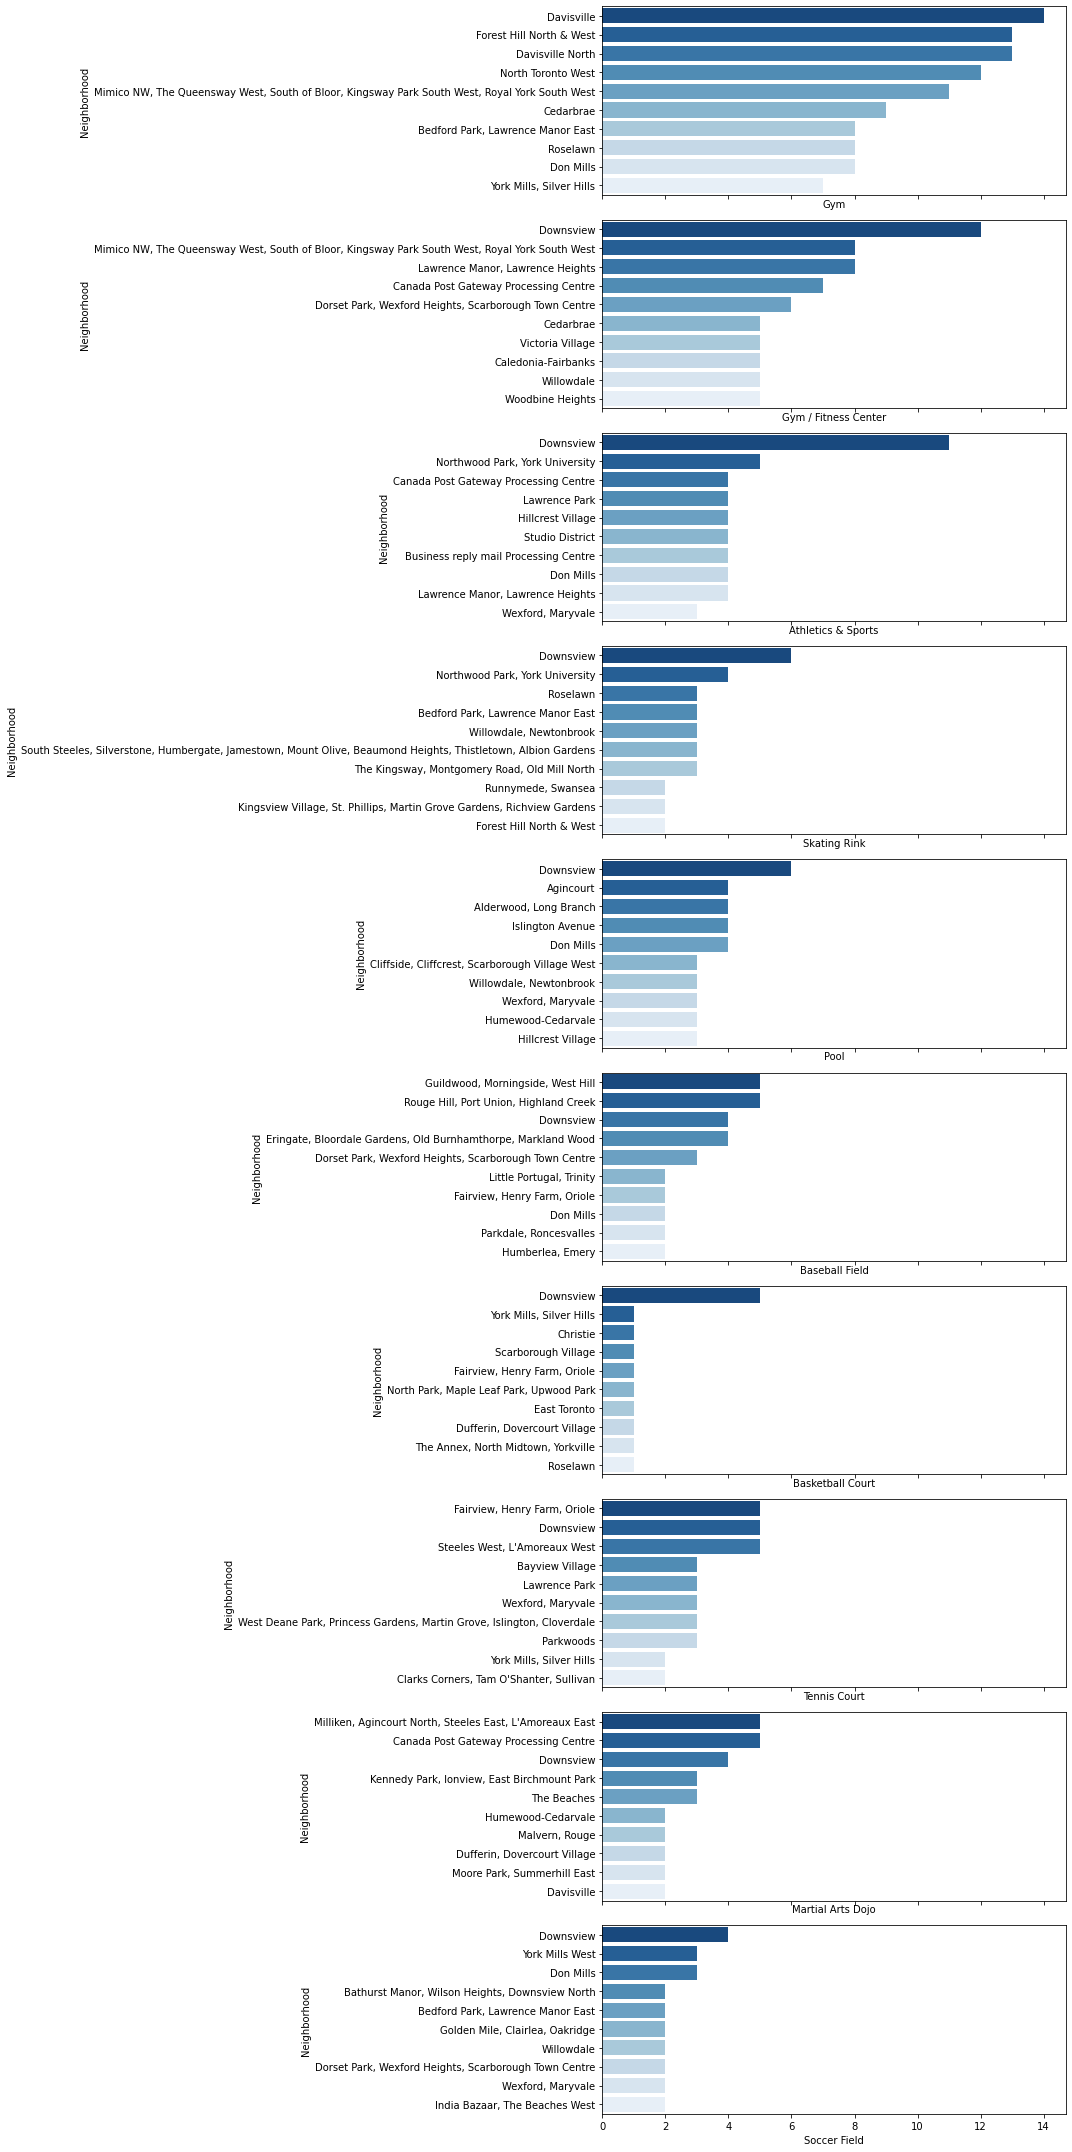

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(10, 1, figsize=(15,30), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_sport.index.values.tolist()):
    data = venue_counts_sport[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [56]:
Toronto_grouped_sport = Toronto_onehot_sport.groupby('Neighborhood').mean().reset_index()
Toronto_grouped_sport.head()

,Neighborhood,Athletics & Sports,Badminton Court,Baseball Field,Basketball Court,Boxing Gym,Climbing Gym,College Rec Center,College Stadium,Curling Ice,Golf Course,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hockey Arena,Hockey Field,Hockey Rink,Martial Arts Dojo,Outdoors & Recreation,Paintball Field,Pilates Studio,Pool,Recreation Center,Rock Climbing Spot,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stadium,Tennis Court,Volleyball Court,Yoga Studio
0,Agincourt,0.090909,0.045455,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.045455,0.181818,0.181818,0.0,0.0,0.045455,0.0,0.000000,0.045455,0.0,0.0,0.00,0.181818,0.045455,0.0,0.00,0.045455,0.000000,0.000000,0.00,0.0,0.045455,0.0,0.045455
1,"Alderwood, Long Branch",0.117647,0.000000,0.058824,0.000,0.0,0.0,0.0,0.0,0.0,0.058824,0.117647,0.176471,0.0,0.0,0.000000,0.0,0.058824,0.000000,0.0,0.0,0.00,0.235294,0.000000,0.0,0.00,0.117647,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.058824
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.076923,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.153846,0.153846,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.076923,0.0,0.00,0.076923,0.076923,0.153846,0.00,0.0,0.153846,0.0,0.076923
3,Bayview Village,0.000000,0.000000,0.000000,0.125,0.0,0.0,0.0,0.0,0.0,0.125000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.25,0.125000,0.000000,0.000000,0.00,0.0,0.375000,0.0,0.000000
4,"Bedford Park, Lawrence Manor East",0.040000,0.000000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.040000,0.320000,0.080000,0.0,0.0,0.000000,0.0,0.000000,0.040000,0.0,0.0,0.04,0.120000,0.000000,0.0,0.00,0.120000,0.000000,0.080000,0.04,0.0,0.000000,0.0,0.080000


#### Let's write a function to sort the venues in descending order.

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [58]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))  
        
columns

['Neighborhood',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue']

In [59]:
# create a new dataframe
neighborhoods_venues_sorted_sport = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_sport['Neighborhood'] = Toronto_grouped_sport['Neighborhood']
for ind in np.arange(Toronto_grouped_sport.shape[0]):
    neighborhoods_venues_sorted_sport.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped_sport.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_sport.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt,Gym,Gym / Fitness Center,Pool
1,"Alderwood, Long Branch",Pool,Gym / Fitness Center,Athletics & Sports
2,"Bathurst Manor, Wilson Heights, Downsview North",Tennis Court,Gym / Fitness Center,Soccer Field
3,Bayview Village,Tennis Court,Skate Park,Basketball Court
4,"Bedford Park, Lawrence Manor East",Gym,Pool,Skating Rink


### Cluster Neighborhoods

Create a data frame with the total count of sport venues for each neighborhood

In [60]:
Toronto_grouped_sport_count= Toronto_onehot_sport.groupby('Neighborhood').sum().reset_index()
# create a new column which has the sum of all columns for each row
Toronto_grouped_sport_count['#sport venues']=Toronto_grouped_sport_count.sum(axis=1)
# drop all other columns
Toronto_grouped_sport_count.drop(sport_categories,axis=1,inplace=True)
Toronto_grouped_sport_count.head()

,Neighborhood,#sport venues
0,Agincourt,22
1,"Alderwood, Long Branch",17
2,"Bathurst Manor, Wilson Heights, Downsview North",13
3,Bayview Village,8
4,"Bedford Park, Lawrence Manor East",25


Create a data frame with the total count of shopping venues for each neighborhood

In [61]:
Toronto_grouped_shop_count= Toronto_onehot_shop[['Neighborhood','Shopping Mall', 'Shopping Plaza']].groupby('Neighborhood').sum().reset_index()
# create a new column which has the sum of all columns for each row
Toronto_grouped_shop_count['#shopping venues']=Toronto_grouped_shop_count.sum(axis=1)
# drop all other columns
Toronto_grouped_shop_count.drop(['Shopping Mall', 'Shopping Plaza'],axis=1,inplace=True)
Toronto_grouped_shop_count.head()

,Neighborhood,#shopping venues
0,Agincourt,5
1,"Alderwood, Long Branch",3
2,"Bathurst Manor, Wilson Heights, Downsview North",1
3,Bayview Village,4
4,Berczy Park,2


In [62]:
# create a new data frame with only Sporting Goods Shop column and groupby Neighborhood
Toronto_grouped_SportGoodsShop_count= Toronto_onehot_shop[['Neighborhood','Sporting Goods Shop']].groupby('Neighborhood').sum().reset_index()
# create a new column which has the sum of all columns for each row
Toronto_grouped_SportGoodsShop_count.head()

,Neighborhood,Sporting Goods Shop
0,Agincourt,1
1,"Alderwood, Long Branch",0
2,"Bathurst Manor, Wilson Heights, Downsview North",0
3,Bayview Village,0
4,Berczy Park,0


Combine the previous data frames

In [63]:
#Toronto_grouped_sport.merge(Toronto_grouped_shop, on='Neighborhood')
Toronto_merged_sport_shop=Toronto_grouped_sport_count.merge(Toronto_grouped_shop_count, on='Neighborhood').merge(Toronto_grouped_SportGoodsShop_count, on='Neighborhood')
Toronto_merged_sport_shop.head()

,Neighborhood,#sport venues,#shopping venues,Sporting Goods Shop
0,Agincourt,22,5,1
1,"Alderwood, Long Branch",17,3,0
2,"Bathurst Manor, Wilson Heights, Downsview North",13,1,0
3,Bayview Village,8,4,0
4,Berczy Park,8,2,0


Remove the neighborhoods with one or more sporting goods shop from the dataframe

In [64]:
Toronto_merged_sport_shop.drop(Toronto_merged_sport_shop[Toronto_merged_sport_shop['Sporting Goods Shop']!=0].index,inplace=True)
# drop the 'Sporting Goods Shop' column
Toronto_merged_sport_shop.drop('Sporting Goods Shop',axis=1,inplace=True)
Toronto_merged_sport_shop.head()

,Neighborhood,#sport venues,#shopping venues
1,"Alderwood, Long Branch",17,3
2,"Bathurst Manor, Wilson Heights, Downsview North",13,1
3,Bayview Village,8,4
4,Berczy Park,8,2
5,"Birch Cliff, Cliffside West",17,1


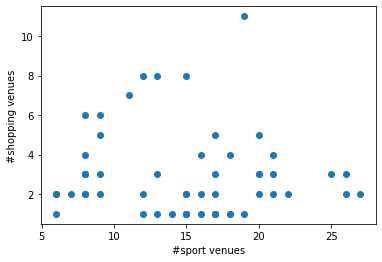

In [65]:
# visualize the data with a scatter plot
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.xlabel("#sport venues")
plt.ylabel("#shopping venues")
plt.show()

Run *k*-means to count Neighborhoods for each cluster label for variable cluster size

In [66]:
Toronto_grouped_clustering = Toronto_merged_sport_shop.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

**The Elbow Method** - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [67]:
sum_of_squared_distances = []
K = range(2,20)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(Toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

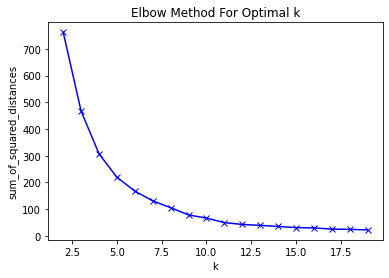

In [68]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

**The Silhouette Method** - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [69]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,20)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(Toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(Toronto_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

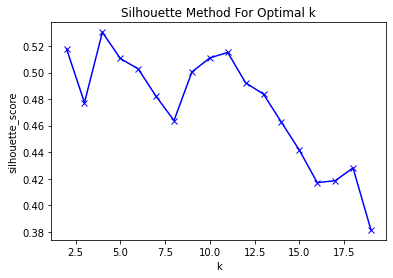

In [70]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [71]:
pd.DataFrame({'Sil':sil,'ksil':K_sil}).head(15)

,Sil,ksil
0,0.517841,2
1,0.477340,3
2,0.530407,4
3,0.510621,5
4,0.502790,6
5,0.482113,7
6,0.463813,8
7,0.500463,9
8,0.511036,10
9,0.515202,11


### Let's set number of clusters = 6

In [72]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(Toronto_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({0: 15, 5: 13, 2: 10, 1: 8, 6: 4, 3: 4, 4: 1})


Let's create a new dataframe that includes the cluster as well as the neighborhood information

In [73]:
# add clustering labels
try:
    Toronto_merged_sport_shop.drop('Cluster Labels', axis=1)
except:
    Toronto_merged_sport_shop.insert(0, 'Cluster Labels', kmeans.labels_)

In [74]:
Toronto_merged_sport_shop.head()

,Cluster Labels,Neighborhood,#sport venues,#shopping venues
1,5,"Alderwood, Long Branch",17,3
2,2,"Bathurst Manor, Wilson Heights, Downsview North",13,1
3,0,Bayview Village,8,4
4,0,Berczy Park,8,2
5,5,"Birch Cliff, Cliffside West",17,1


In [75]:
# merge neighborhoods_venues_sorted with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged_sport_shop = Toronto_merged_sport_shop.join(df.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged_sport_shop.head()

,Cluster Labels,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
1,5,"Alderwood, Long Branch",17,3,M8W,Etobicoke,43.602414,-79.543484
2,2,"Bathurst Manor, Wilson Heights, Downsview North",13,1,M3H,North York,43.754328,-79.442259
3,0,Bayview Village,8,4,M2K,North York,43.786947,-79.385975
4,0,Berczy Park,8,2,M5E,Downtown Toronto,43.644771,-79.373306
5,5,"Birch Cliff, Cliffside West",17,1,M1N,Scarborough,43.692657,-79.264848


Finally, let's visualize the resulting clusters

In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged_sport_shop['Latitude'], Toronto_merged_sport_shop['Longitude'], Toronto_merged_sport_shop['Neighborhood'], Toronto_merged_sport_shop['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Results

In [77]:
required_column_indices = [2,3,5]
required_column = [list(Toronto_merged_sport_shop.columns.values)[i] for i in required_column_indices]
#required_column_indices = [2,3,6]
required_column

['#sport venues', '#shopping venues', 'Borough']

#### Cluster 1

In [78]:
cluster_1 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 0, Toronto_merged_sport_shop.columns[1:12]]
cluster_1.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
3,Bayview Village,8,4,M2K,North York,43.786947,-79.385975
4,Berczy Park,8,2,M5E,Downtown Toronto,43.644771,-79.373306
13,"Commerce Court, Victoria Hotel",6,2,M5L,Downtown Toronto,43.648198,-79.379817
23,"First Canadian Place, Underground city",6,2,M5X,Downtown Toronto,43.648429,-79.382280
25,"Garden District, Ryerson",9,6,M5B,Downtown Toronto,43.657162,-79.378937


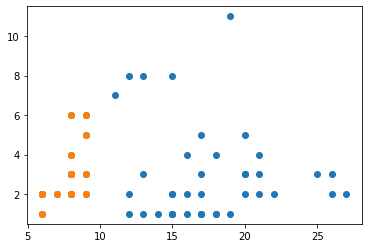

In [79]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_1['#sport venues'],y=cluster_1['#shopping venues'])
plt.show()

#### Cluster 2

In [80]:
cluster_2 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 1, Toronto_merged_sport_shop.columns[1:12]]
cluster_2

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
22,"Fairview, Henry Farm, Oriole",21,4,M2J,North York,43.778517,-79.346556
26,Glencairn,20,3,M6B,North York,43.709577,-79.445073
37,"Kingsview Village, St. Phillips, Martin Grove ...",21,2,M9R,Etobicoke,43.688905,-79.554724
38,"Lawrence Manor, Lawrence Heights",22,2,M6A,North York,43.718518,-79.464763
48,Parkwoods,20,5,M3A,North York,43.753259,-79.329656
62,"Summerhill West, Rathnelly, South Hill, Forest...",20,2,M4V,Central Toronto,43.686412,-79.400049
70,Victoria Village,21,3,M4A,North York,43.725882,-79.315572
76,"Willowdale, Newtonbrook",20,3,M2M,North York,43.789053,-79.408493


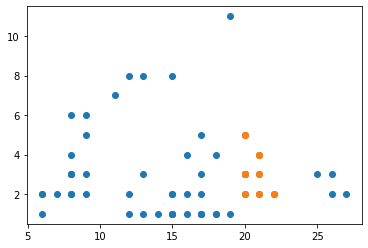

In [81]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_2['#sport venues'],y=cluster_2['#shopping venues'])
plt.show()

#### Cluster 3

In [82]:
cluster_3 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 2, Toronto_merged_sport_shop.columns[1:12]]
cluster_3.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
2,"Bathurst Manor, Wilson Heights, Downsview North",13,1,M3H,North York,43.754328,-79.442259
19,"Dufferin, Dovercourt Village",15,2,M6H,West Toronto,43.669005,-79.442259
32,"Humberlea, Emery",15,1,M9M,North York,43.724766,-79.532242
34,Islington Avenue,15,2,M9A,Etobicoke,43.667856,-79.532242
36,"Kensington Market, Chinatown, Grange Park",13,3,M5T,Downtown Toronto,43.653206,-79.400049


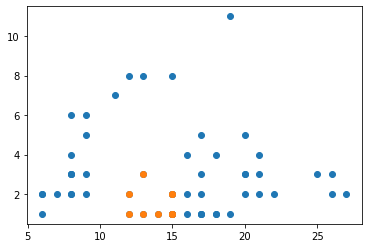

In [83]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_3['#sport venues'],y=cluster_3['#shopping venues'])
plt.show()

#### Cluster 4

In [84]:
cluster_4 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 3, Toronto_merged_sport_shop.columns[1:12]]
cluster_4.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
9,Central Bay Street,12,8,M5G,Downtown Toronto,43.657952,-79.387383
11,Church and Wellesley,11,7,M4Y,Downtown Toronto,43.665860,-79.383160
49,"Queen's Park, Ontario Provincial Government",13,8,M7A,Downtown Toronto,43.662301,-79.389494
69,"University of Toronto, Harbord",15,8,M5S,Downtown Toronto,43.662696,-79.400049


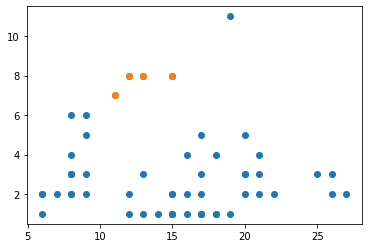

In [85]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_4['#sport venues'],y=cluster_4['#shopping venues'])
plt.show()

#### Cluster 5

In [86]:
cluster_5 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 4, Toronto_merged_sport_shop.columns[1:12]]
cluster_5.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
41,"Milliken, Agincourt North, Steeles East, L'Amo...",19,11,M1V,Scarborough,43.815252,-79.284577


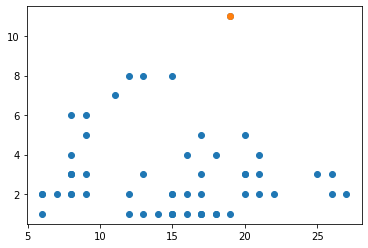

In [87]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_5['#sport venues'],y=cluster_5['#shopping venues'])
plt.show()

#### Cluster 6

In [88]:
cluster_6 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 5, Toronto_merged_sport_shop.columns[1:12]]
cluster_6.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
1,"Alderwood, Long Branch",17,3,M8W,Etobicoke,43.602414,-79.543484
5,"Birch Cliff, Cliffside West",17,1,M1N,Scarborough,43.692657,-79.264848
10,Christie,17,2,M6G,Downtown Toronto,43.669542,-79.422564
12,"Clarks Corners, Tam O'Shanter, Sullivan",16,4,M1T,Scarborough,43.781638,-79.304302
21,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",19,1,M9C,Etobicoke,43.643515,-79.577201


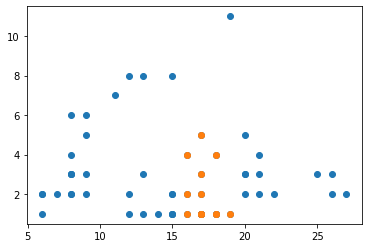

In [89]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_6['#sport venues'],y=cluster_6['#shopping venues'])
plt.show()

#### Cluster 7

In [90]:
cluster_7 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 6, Toronto_merged_sport_shop.columns[1:12]]
cluster_7.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
7,Canada Post Gateway Processing Centre,26,2,M7R,Mississauga,43.636966,-79.615819
42,"Mimico NW, The Queensway West, South of Bloor,...",26,3,M8Z,Etobicoke,43.628841,-79.520999
74,"Wexford, Maryvale",25,3,M1R,Scarborough,43.750071,-79.295849
78,York Mills West,27,2,M2P,North York,43.752758,-79.400049


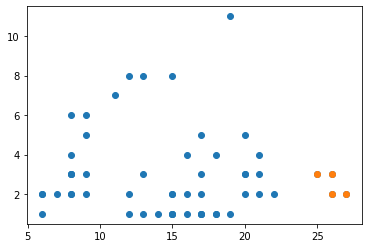

In [91]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_7['#sport venues'],y=cluster_7['#shopping venues'])
plt.show()

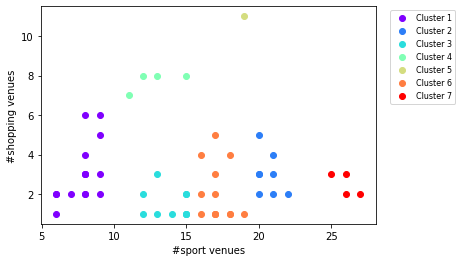

In [130]:
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

a=plt.scatter(x=cluster_1['#sport venues'],y=cluster_1['#shopping venues'],c=rainbow[0])
b=plt.scatter(x=cluster_2['#sport venues'],y=cluster_2['#shopping venues'],c=rainbow[1])
c=plt.scatter(x=cluster_3['#sport venues'],y=cluster_3['#shopping venues'],c=rainbow[2])
d=plt.scatter(x=cluster_4['#sport venues'],y=cluster_4['#shopping venues'],c=rainbow[3])
e=plt.scatter(x=cluster_5['#sport venues'],y=cluster_5['#shopping venues'],c=rainbow[4])
f=plt.scatter(x=cluster_6['#sport venues'],y=cluster_6['#shopping venues'],c=rainbow[5])
g=plt.scatter(x=cluster_7['#sport venues'],y=cluster_7['#shopping venues'],c=rainbow[6])

plt.xlabel("#sport venues")
plt.ylabel("#shopping venues")
plt.legend((a, b, c, d, e, f, g),
           ('Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=8,
           bbox_to_anchor=(1.25, 1))

In [136]:
# let's visualize the desired cluster on the map
# select a cluster
cluster=7
Selected=Toronto_merged_sport_shop[Toronto_merged_sport_shop['Cluster Labels']==cluster-1]
Selected

,Cluster Labels,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
7,6,Canada Post Gateway Processing Centre,26,2,M7R,Mississauga,43.636966,-79.615819
42,6,"Mimico NW, The Queensway West, South of Bloor,...",26,3,M8Z,Etobicoke,43.628841,-79.520999
74,6,"Wexford, Maryvale",25,3,M1R,Scarborough,43.750071,-79.295849
78,6,York Mills West,27,2,M2P,North York,43.752758,-79.400049


In [140]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(Selected['Latitude'], Selected['Longitude'], Selected['Neighborhood']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters